In [27]:
from faker import Faker
import random
import yaml
from datetime import datetime, timedelta
import os
import pandas as pd

# Load product data
with open(file="product_data.yaml", mode='r') as file:
    product_data = yaml.safe_load(file)

# Initialize Faker
faker = Faker()

# Monthly multipliers for seasonality
MONTHLY_SEASONALITY = {
    1: 0.8,  # January (low post-holiday season)
    2: 0.9,  # February
    3: 1.0,  # March
    4: 1.1,  # April (Easter-related uplift)
    5: 1.0,  # May
    6: 0.95, # June (slightly lower before summer promotions)
    7: 1.3,  # July (moderate uplift for mid-year promotions)
    8: 1.0,  # August
    9: 1.2,  # September (back-to-school season)
    10: 1.3, # October (pre-holiday shopping begins)
    11: 1.8, # November (Black Friday/Cyber Monday)
    12: 1.5  # December (holiday season)
}

# Base transition probabilities
BASE_TRANSITION_PROBABILITIES = {
    "view": [0.5, 0.4, 0.1],
    "click": [0.3, 0.4, 0.3],
    "purchase": [0.0, 0.0, 1.0]
}

# Parameters
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 12, 31)
daily_user_base = 800
weekend_multiplier = 1.5  # Higher activity during weekends

csv_file_path = 'user_data.csv'
if os.path.exists(csv_file_path):
    os.remove(csv_file_path)

# Generate data
current_date = start_date
all_data = []

while current_date <= end_date:
    # Determine multiplier for the current day
    month_multiplier = MONTHLY_SEASONALITY[current_date.month]
    day_multiplier = month_multiplier

    # Apply weekend multiplier
    if current_date.weekday() >= 5:  # Saturday or Sunday
        day_multiplier *= weekend_multiplier

    # Introduce small daily variation for sales count
    daily_variation = random.uniform(0.9, 1.1)

    # Adjust daily user base (including variation)
    n_users = int(daily_user_base * day_multiplier * daily_variation)

    for _ in range(n_users):
        user_id = faker.uuid4()
        actions = []
        max_actions = random.randint(5, 20)
        action = "view"

        # Adjust probabilities based on day multiplier
        transition_probs = BASE_TRANSITION_PROBABILITIES.copy()
        if day_multiplier > 1:  # Adjust during high activity periods
            transition_probs["view"] = [0.4, 0.4, 0.2]
            transition_probs["click"] = [0.2, 0.4, 0.4]

        for _ in range(max_actions):
            action = random.choices(
                population=["view", "click", "purchase"],
                weights=transition_probs[action]
            )[0]
            actions.append(action)
            if action == "purchase":
                break

        # Randomly select a category and product
        category = faker.random_element(elements=product_data.keys())
        product = faker.random_element(elements=product_data[category])

        # Generate revenue and ensure variability
        base_price = product["price"]
        revenue = base_price * random.uniform(0.8, 1.2) * day_multiplier

        # Add data entry
        data = {
            "timestamp": (current_date + timedelta(seconds=random.randint(0, 86400))).strftime('%Y-%m-%d %H:%M:%S'),
            "user_id": user_id,
            "action": ", ".join(actions),
            "category": category,
            "product_name": product["name"],
            "price": round(revenue, 2)  # Apply revenue multiplier
        }
        all_data.append(data)

    current_date += timedelta(days=1)

# Convert to DataFrame
df_data = pd.DataFrame(all_data)

print(f"Data generation complete with {len(df_data)} records.")

Data generation complete with 770629 records.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta

In [29]:
dfd = df_data.copy()
dfd["Date"] = pd.to_datetime(dfd["timestamp"]).dt.normalize()
dfd.head()

,timestamp,user_id,action,category,product_name,price,Date
0,2023-01-01 07:26:01,083bdbfe-7a56-45a8-a36a-d70430e8b5fe,"click, purchase",Clothing,Sneakers,83.37,2023-01-01
1,2023-01-01 16:57:43,f663e976-c603-4db4-83d5-37b662fd4cb6,purchase,Books,Harry Potter and the Sorcerer's Stone,28.11,2023-01-01
2,2023-01-01 14:24:54,a88bf509-9af1-453b-8224-db34fe60980f,"view, view, click, click, view, purchase",Electronics,TV,871.07,2023-01-01
3,2023-01-01 07:41:46,61503580-0f28-4d08-a137-16315cee780b,"click, click, click, purchase",Books,The Lord of the Rings,21.19,2023-01-01
4,2023-01-01 20:57:09,d263b971-d481-4dc7-b20a-39397da60b6b,"click, purchase",Electronics,Camera,836.59,2023-01-01


## EDA 

In [30]:
df_eda = dfd.groupby("Date").agg(
    revenue=("price", "sum"),
    salescount=("user_id", "count")
)

dfeda = df_eda.copy().reset_index()

dfeda["Month"] = dfeda["Date"].apply(lambda x: x.month) # month of the date
dfeda["Year"] = dfeda["Date"].apply(lambda x: x.year) # year of the date
dfeda["Year-Month"] = dfeda["Date"].apply(lambda x: f"{x.year}-{x.month:02d}")  # Combine year and month

dfeda.head(60)

,Date,revenue,salescount,Month,Year,Year-Month
0,2023-01-01,221433.46,1020,1,2023,2023-01
1,2023-01-02,73982.86,613,1,2023,2023-01
2,2023-01-03,90446.57,664,1,2023,2023-01
3,2023-01-04,74924.60,579,1,2023,2023-01
4,2023-01-05,87512.78,648,1,2023,2023-01
5,2023-01-06,79051.86,585,1,2023,2023-01
6,2023-01-07,183833.94,944,1,2023,2023-01
7,2023-01-08,189356.18,1025,1,2023,2023-01
8,2023-01-09,78569.14,618,1,2023,2023-01
9,2023-01-10,79093.89,601,1,2023,2023-01


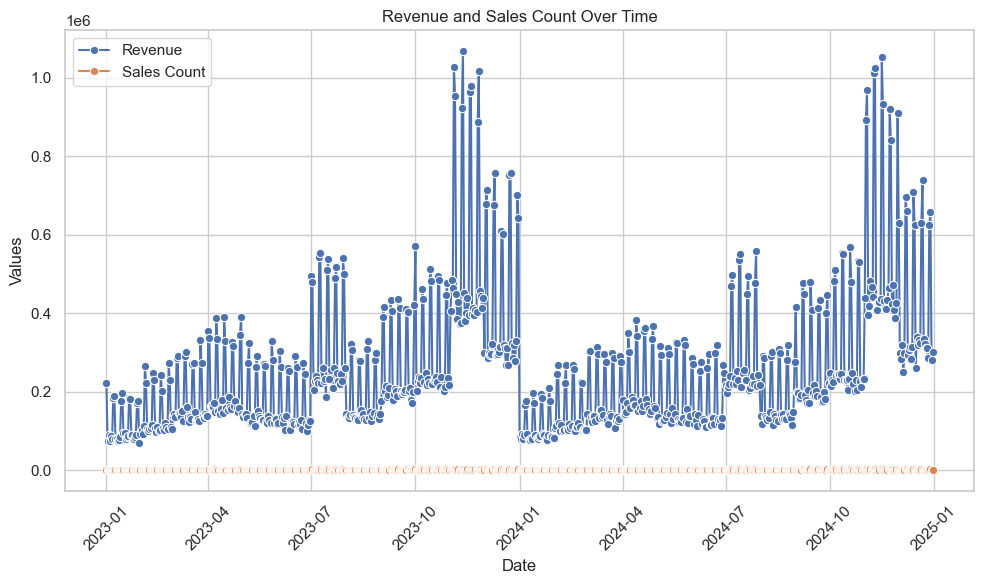

In [31]:
# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot revenue
sns.lineplot(data=df_eda, x="Date", y="revenue", label="Revenue", marker="o")

# Plot salescount
sns.lineplot(data=df_eda, x="Date", y="salescount", label="Sales Count", marker="o")

# Add titles and labels
plt.title("Revenue and Sales Count Over Time")
plt.xlabel("Date")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# Monthly Trend

dfeda_monthly = dfeda.groupby("Year-Month")[["revenue", "salescount"]].sum()
dfeda_monthly


,revenue,salescount
Year-Month,,
2023-01,3509479.73,22609
2023-02,4012002.11,22640
2023-03,5457046.27,27941
2023-04,6701008.27,30461
2023-05,5287064.03,27519
2023-06,4772969.42,26068
2023-07,9994189.89,37772
2023-08,5553068.97,28631
2023-09,7824819.32,33214


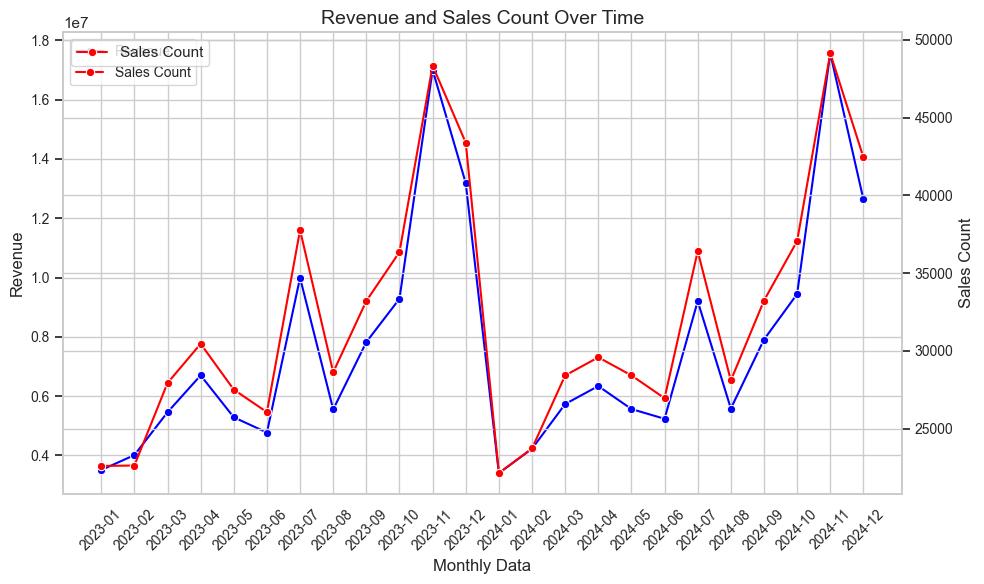

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot revenue on the primary y-axis
sns.lineplot(data=dfeda_monthly, x="Year-Month", y="revenue", label="Revenue", marker="o", ax=ax1, color="blue")
ax1.set_ylabel("Revenue", fontsize=12)
ax1.set_xlabel("Monthly Data", fontsize=12)
ax1.tick_params(axis='y', labelsize=10)
ax1.tick_params(axis='x', rotation=45, labelsize=10)

# Create a secondary y-axis for salescount
ax2 = ax1.twinx()
sns.lineplot(data=dfeda_monthly, x="Year-Month", y="salescount", label="Sales Count", marker="o", ax=ax2, color="red")
ax2.set_ylabel("Sales Count", fontsize=12)  # Change y-axis label color
ax2.tick_params(axis='y', labelsize=10)  # Change tick label color

# Add titles and legends
plt.title("Revenue and Sales Count Over Time", fontsize=14)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper left", fontsize=10)

plt.tight_layout()
plt.show()

#### We have achieved to simulate a real retail ecommerce user data in the online platforms.

# Final Table to use as User Data

In [35]:
df_data.head()

,timestamp,user_id,action,category,product_name,price
0,2023-01-01 07:26:01,083bdbfe-7a56-45a8-a36a-d70430e8b5fe,"click, purchase",Clothing,Sneakers,83.37
1,2023-01-01 16:57:43,f663e976-c603-4db4-83d5-37b662fd4cb6,purchase,Books,Harry Potter and the Sorcerer's Stone,28.11
2,2023-01-01 14:24:54,a88bf509-9af1-453b-8224-db34fe60980f,"view, view, click, click, view, purchase",Electronics,TV,871.07
3,2023-01-01 07:41:46,61503580-0f28-4d08-a137-16315cee780b,"click, click, click, purchase",Books,The Lord of the Rings,21.19
4,2023-01-01 20:57:09,d263b971-d481-4dc7-b20a-39397da60b6b,"click, purchase",Electronics,Camera,836.59


In [36]:
users = df_data